<a href="https://colab.research.google.com/github/Enforcer03/GoDaddy-microbusiness-forcasting/blob/Enforcer03-varmax-partial-trained/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import torch
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
df=pd.read_csv('train.csv')
census_starter=pd.read_csv('census_starter.csv')
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001.0,Autauga County,Alabama,2019-08-01,3.007682,1249.0
1,1001_2019-09-01,1001.0,Autauga County,Alabama,2019-09-01,2.884870,1198.0
2,1001_2019-10-01,1001.0,Autauga County,Alabama,2019-10-01,3.055843,1269.0
3,1001_2019-11-01,1001.0,Autauga County,Alabama,2019-11-01,2.993233,1243.0
4,1001_2019-12-01,1001.0,Autauga County,Alabama,2019-12-01,2.993233,1243.0
...,...,...,...,...,...,...,...
86262,41013_2022-05-01,41013.0,Crook County,Oregon,2022-05-01,4.628073,881.0
86263,41013_2022-06-01,41013.0,Crook County,Oregon,2022-06-01,4.659592,887.0
86264,41013_2022-07-01,41013.0,Crook County,Oregon,2022-07-01,4.691112,893.0
86265,41013_2022-08-01,41013.0,Crook County,Oregon,2022-08-01,4.748897,904.0


In [3]:
df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])
df = df.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001.0,Autauga County,Alabama,2019-08-01,3.007682,1249.0
1,1001_2019-09-01,1001.0,Autauga County,Alabama,2019-09-01,2.884870,1198.0
2,1001_2019-10-01,1001.0,Autauga County,Alabama,2019-10-01,3.055843,1269.0
3,1001_2019-11-01,1001.0,Autauga County,Alabama,2019-11-01,2.993233,1243.0
4,1001_2019-12-01,1001.0,Autauga County,Alabama,2019-12-01,2.993233,1243.0
...,...,...,...,...,...,...,...
86262,41013_2022-05-01,41013.0,Crook County,Oregon,2022-05-01,4.628073,881.0
86263,41013_2022-06-01,41013.0,Crook County,Oregon,2022-06-01,4.659592,887.0
86264,41013_2022-07-01,41013.0,Crook County,Oregon,2022-07-01,4.691112,893.0
86265,41013_2022-08-01,41013.0,Crook County,Oregon,2022-08-01,4.748897,904.0


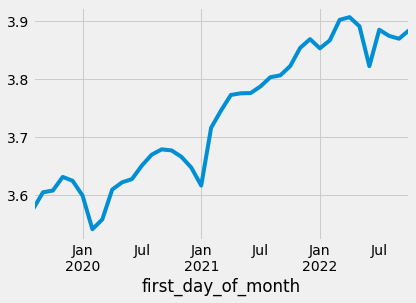

In [4]:
df.groupby(['first_day_of_month']).mean()['microbusiness_density'].plot()

In [5]:
df=(df[['cfips','first_day_of_month','microbusiness_density']].pivot('cfips', 'first_day_of_month')
   .stack(level=0)
   .rename_axis(index=['cfips', 'hour'], columns=None)
).reset_index().transpose()

df=df.drop('hour',axis=0)
df.columns=df.iloc[0]
df=df.drop('cfips',axis=0)
df

cfips,1001.0,1003.0,1005.0,1007.0,1009.0,1011.0,1013.0,1015.0,1017.0,1019.0,...,40149.0,40151.0,40153.0,41001.0,41003.0,41005.0,41007.0,41009.0,41011.0,41013.0
2019-08-01 00:00:00,3.007682,7.239156,1.073138,1.310777,1.544148,0.926372,0.674981,2.691544,1.486542,1.104277,...,1.525207,2.698651,1.485526,2.491436,5.651493,10.027122,6.555875,4.033103,3.079236,5.181288
2019-09-01 00:00:00,2.88487,7.290936,0.995794,1.305176,1.575892,0.998556,0.739265,2.703752,1.355156,1.089747,...,1.478635,2.739539,1.536313,2.771722,5.617473,10.37956,6.290893,4.104621,3.069473,5.42148
2019-10-01 00:00:00,3.055843,7.425439,1.160149,1.254761,1.546415,0.974495,0.713551,2.693764,1.355156,1.084903,...,1.501921,2.739539,1.517268,2.59265,5.628359,10.385016,6.63766,4.094404,3.057758,5.553014
2019-11-01 00:00:00,2.993233,7.426071,1.000628,1.254761,1.573625,1.022618,1.054256,2.73927,1.362664,1.084903,...,1.478635,2.794058,1.561706,2.639365,5.61203,10.381165,6.35632,4.107175,3.075331,5.553014
2019-12-01 00:00:00,2.993233,7.470274,1.000628,1.265965,1.555485,1.034649,1.054256,2.729281,1.343894,1.089747,...,1.37385,2.780428,1.593448,2.654936,5.590257,10.355486,6.405391,4.107175,3.055805,5.512982
2020-01-01 00:00:00,2.96909,7.413655,1.027229,1.253638,1.573217,1.060717,1.060871,2.719628,1.31991,1.079399,...,1.430917,2.742732,1.631478,2.741322,5.472544,10.151243,6.631026,4.057825,3.037886,5.290798
2020-02-01 00:00:00,2.909326,7.282522,1.022314,1.248041,1.536999,1.036333,1.060871,2.745211,1.331096,1.069675,...,1.360544,2.729018,1.62508,2.764619,5.392497,10.057525,6.441016,4.005028,3.012668,5.123191
2020-03-01 00:00:00,2.933231,7.30961,1.032144,1.264831,1.541526,1.060717,1.009121,2.756335,1.301268,1.074537,...,1.372273,2.591881,1.599488,2.733556,5.395165,10.131679,6.508647,4.017599,2.993269,5.084083
2020-04-01 00:00:00,3.000167,7.568799,1.086209,1.270428,1.577744,1.011948,0.996183,2.818625,1.327368,1.05995,...,1.419188,2.674164,1.612284,2.787916,5.491221,10.280934,6.331519,3.942175,2.995208,5.112018
2020-05-01 00:00:00,3.004948,7.603275,1.081294,1.287217,1.575481,0.890027,0.996183,2.834197,1.342282,1.084261,...,1.466104,2.674164,1.650672,2.842277,5.513902,10.281566,6.241345,3.954746,2.995208,5.050561


In [6]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults

## PARTIALLY TRAINING

In [7]:
df=df.fillna(method='bfill')
train=df[:pd.to_datetime('2022-03-01')][[1001,  1003,  1005,  1007,  1009,  1011,  1013,  1015,  1017,
             1019]]
valid=df[pd.to_datetime('2022-04-01'):][[1001,  1003,  1005,  1007,  1009,  1011,  1013,  1015,  1017,
             1019]]

In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
df.columns

Float64Index([ 1001.0,  1003.0,  1005.0,  1007.0,  1009.0,  1011.0,  1013.0,
               1015.0,  1017.0,  1019.0,
              ...
              40149.0, 40151.0, 40153.0, 41001.0, 41003.0, 41005.0, 41007.0,
              41009.0, 41011.0, 41013.0],
             dtype='float64', name='cfips', length=2212)

In [10]:
with tf.device('/device:GPU:0'):
  model1 = VARMAX(np.asarray(train), order=(1,2), trend='ct') # c indicates a constant trend
  results1 = model1.fit()
with tf.device('/device:GPU:0'):
  model2 = VARMAX(np.asarray(train), order=(1,4), trend='ct') # c indicates a constant trend
  results2 = model2.fit()
with tf.device('/device:GPU:0'):
  model3 = VARMAX(np.asarray(train), order=(1,5), trend='ct') # c indicates a constant trend
  results3 = model3.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameter

In [11]:
forecast1=np.array(results1.forecast(10))
forecast2=np.array(results2.forecast(10))
forecast3=np.array(results3.forecast(10))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [12]:
def SMAPE(y_true, y_pred):
    ans = 0
    for i in range(len(y_true)):
      num = np.abs(y_true[i] - y_pred[i])
      denom = (np.abs(y_true[i]) + np.abs(y_pred[i]))/2
      ans = ans + np.sum((np.divide(num,denom)))
    return (100/(len(y_true)*len(y_true[0])))*ans 

In [13]:
SMAPE(np.array(valid)[:1],np.array(forecast1)[:len(valid)])

5.939995332694217

In [18]:
SMAPE(np.array(valid)[:1],np.array(forecast3)[:len(valid)])

1.6871029403471534

In [20]:
SMAPE(np.array(valid)[:1],np.array(forecast2)[:len(valid)])

1.687103315911957

In [15]:
SMAPE(np.array(valid),np.array(forecast2[:len(valid)]))

4.362470109327727

In [16]:
SMAPE(np.array(valid),np.array(forecast3[:len(valid)]))

4.362466781062729

In [17]:
val_true, val_pred_arima, val_pred_arima_last = [], [], []
arima_cfips_set, lastval_cfips_set = set(), set()
for cfips_temp in tqdm.tqdm(unique_tr_cfips):
    temp_train = train_df[train_df.cfips == cfips_temp]
    temp_train["first_day_of_month"] = pd.to_datetime(temp_train["first_day_of_month"])
    tr = temp_train.sort_values(by = "first_day_of_month")["microbusiness_density"].values.tolist()
    tr, val = tr[:-1], tr[-1]
    
    p_list = [0,1]
    d_list = [0,1]
    q_list = [0,1]
    ans = float("inf")

    for p in p_list:
      for d in d_list:
            for q in q_list:
                order = (p,d,q)
                try:
                    model = ARIMA(tr, order=order).fit()
                    pred_val = model.forecast(1)
                except:
                    pred_val = [tr[-1]]
                if SMAPE(pred_val, [val])<ans:
                    final_pdq = [p,d,q]
                    ans = SMAPE(pred_val, [val])

    optimized_arima_dict[cfips_temp] = final_pdq + [pred_val[0], ans]
    val_true.append(val)
    val_pred_arima.append(pred_val[0])
    if abs(tr[-1] - val)<ans:
        lastval_cfips_set.add(cfips_temp)
        val_pred_arima_last.append(tr[-1])
    else:
        arima_cfips_set.add(cfips_temp)
        val_pred_arima_last.append(pred_val[0])

NameError: ignored